In [1]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Perceptron
import warnings
warnings.filterwarnings('ignore')
import copy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [2]:
# Import data. Shapes like tilde will crash  ctf-8 so we use latin1
spamDf = pd.read_csv('./Data/spam.csv', encoding='latin1')

In [3]:
# Drop empty columns
spamDf.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
# Rename remaining columns
spamDf.columns = ['label', 'text']

# Flip columns so text is first column
columnsTitles=["text","label"]
spamDf = spamDf.reindex(columns = columnsTitles)
spamDf.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [4]:
# Find all instances of nonstandard punctuation. ie space before a comma but not after
# match on , . ' ! # / @ % ^ ; "
def freqOfNonstardardPunc(message):
    count = 0
    regexList = ['\s,\S', '\s\.\S', '\s\'\S', '\s!\S', '\s#\S', '\s/\S', '\s@\S', '\s%\S', '\s\^\S', '\s;\S', 
                 '\s\?\S', '\s\"\S']
    for regex in regexList:
        prog = re.compile(regex)
        result = prog.findall(message)
        count += len(result)
    return count

In [5]:
# Find number of known spam words
with open('./Data/blacklist.txt') as f:
    content = f.readlines()
# You may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

def spamCount(message):
    count = 0
    for word in content:
        count += message.count(word)
    return count

In [6]:
# Find ratio of capitalized to lowercase letters
def capRatio(message):
    upperCase = sum(1 for c in message if c.isupper())
    lowerCase = sum(1 for c in message if c.islower())
    if lowerCase == 0:
        lowerCase = 1
    return upperCase / lowerCase

In [7]:
# Set of lemmatized words
lemm = WordNetLemmatizer()
def lemSet(wordList):
    wordSet = []
    for word in wordList:
        wordSet.append(lemm.lemmatize(word))
    return wordSet

In [8]:
# Set of stemmed words
ps = PorterStemmer()
 
def stemSet(wordList):
    wordSet = []
    for word in wordList:
        wordSet.append(ps.stem(word))
    return wordSet

In [9]:
# Creates confusion matrix
def plot_confusion_matrix(cm, classes = ['Ham', 'Spam'],
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
# Add column for number of nonstandard punctuations
spamDf['puncCount'] = spamDf.apply(lambda row: freqOfNonstardardPunc(row['text']), axis = 1)

# Add column for number of known spam words
spamDf['spamCount'] = spamDf.apply(lambda row: spamCount(row['text'].lower()), axis = 1)

# Add column for ratio of upper case to lower case words
spamDf['caseRatio'] = spamDf.apply(lambda row: capRatio(row['text']), axis = 1)

# Let's remove all punctuations and stop words from the 'text' column

# Remove all punctuation using regular expression
charTokenizer = RegexpTokenizer(r'\w+')

# Find set of stop words 
stopWords = set(stopwords.words('english'))

# Clean out text column and turn it to lowercase
spamDf['text'] = spamDf.apply(lambda row: [word for word in charTokenizer.tokenize(row['text']) if word.lower() not in stopWords], axis=1)


# Create column of lemmatized words
spamDf['lemWordSet'] = spamDf.apply(lambda row: lemSet(row['text']), axis=1)

#Create column of stemmed words
spamDf['stemWordSet'] = spamDf.apply(lambda row: stemSet(row['text']), axis=1)
spamDf.head()

,text,label,puncCount,spamCount,caseRatio,lemWordSet,stemWordSet
0,"[Go, jurong, point, crazy, Available, bugis, n...",ham,0,0,0.037500,"[Go, jurong, point, crazy, Available, bugis, n...","[Go, jurong, point, crazi, avail, bugi, n, gre..."
1,"[Ok, lar, Joking, wif, u, oni]",ham,0,0,0.125000,"[Ok, lar, Joking, wif, u, oni]","[Ok, lar, joke, wif, u, oni]"
2,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin...",spam,0,0,0.114943,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin...","[free, entri, 2, wkli, comp, win, FA, cup, fin..."
3,"[U, dun, say, early, hor, U, c, already, say]",ham,0,0,0.064516,"[U, dun, say, early, hor, U, c, already, say]","[U, dun, say, earli, hor, U, c, alreadi, say]"
4,"[Nah, think, goes, usf, lives, around, though]",ham,0,0,0.044444,"[Nah, think, go, usf, life, around, though]","[nah, think, goe, usf, live, around, though]"


text
	Naive Bayes score: 0.980967917346
	Naive Bayes report :              precision    recall  f1-score   support

        ham       0.98      0.99      0.99      1587
       spam       0.95      0.90      0.93       252

avg / total       0.98      0.98      0.98      1839



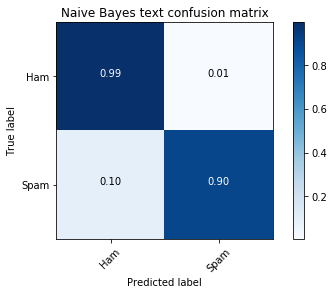

	Naive Bayes roc score: 0.948915293906

	Gradient score: 0.968461120174
	Gradient report :              precision    recall  f1-score   support

        ham       0.97      0.99      0.98      1587
       spam       0.95      0.81      0.88       252

avg / total       0.97      0.97      0.97      1839



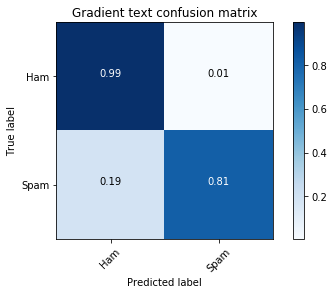

	Gradient roc score: 0.903280373271

	Perceptron score: 0.976073953235
	Perceptron report :              precision    recall  f1-score   support

        ham       0.98      0.99      0.99      1587
       spam       0.94      0.88      0.91       252

avg / total       0.98      0.98      0.98      1839



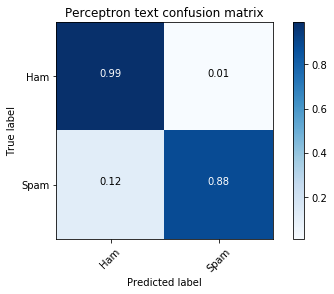

	Perceptron roc score: 0.93773441954


 

lemWordSet
	Naive Bayes score: 0.981511691136
	Naive Bayes report :              precision    recall  f1-score   support

        ham       0.99      0.99      0.99      1587
       spam       0.96      0.90      0.93       252

avg / total       0.98      0.98      0.98      1839



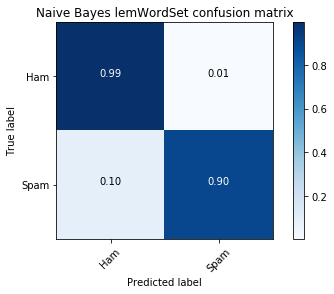

	Naive Bayes roc score: 0.949230353767

	Gradient score: 0.970092441544
	Gradient report :              precision    recall  f1-score   support

        ham       0.97      0.99      0.98      1587
       spam       0.96      0.82      0.88       252

avg / total       0.97      0.97      0.97      1839



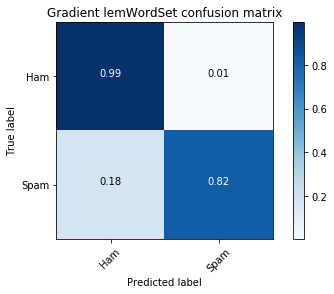

	Gradient roc score: 0.905894619978

	Perceptron score: 0.972811310495
	Perceptron report :              precision    recall  f1-score   support

        ham       0.98      0.99      0.98      1587
       spam       0.91      0.88      0.90       252

avg / total       0.97      0.97      0.97      1839



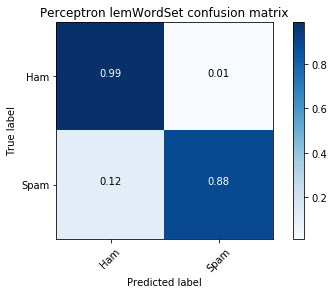

	Perceptron roc score: 0.935844060371


 

stemWordSet
	Naive Bayes score: 0.979336595976
	Naive Bayes report :              precision    recall  f1-score   support

        ham       0.99      0.99      0.99      1587
       spam       0.94      0.91      0.92       252

avg / total       0.98      0.98      0.98      1839



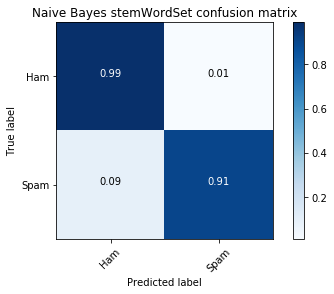

	Naive Bayes roc score: 0.949639181444

	Gradient score: 0.971179989125
	Gradient report :              precision    recall  f1-score   support

        ham       0.97      0.99      0.98      1587
       spam       0.96      0.82      0.89       252

avg / total       0.97      0.97      0.97      1839



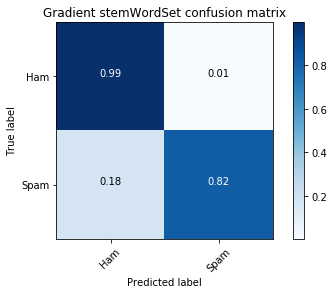

	Gradient roc score: 0.908193806823

	Perceptron score: 0.973355084285
	Perceptron report :              precision    recall  f1-score   support

        ham       0.98      0.99      0.98      1587
       spam       0.92      0.88      0.90       252

avg / total       0.97      0.97      0.97      1839



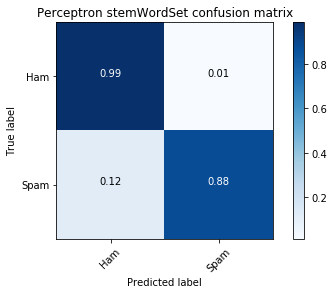

	Perceptron roc score: 0.93449005311


 



In [11]:
# Turn our emails into strings so the sklearn vectorizer
# can handle them

for column in ['text', 'lemWordSet', 'stemWordSet']:
    print(column)
    spamDf[column] = [" ".join(email) for email in spamDf[column].values]
    X_train, X_test, y_train, y_test = train_test_split(spamDf[column], spamDf["label"], test_size=0.33, random_state=42)
    
    # Multinominal Naive Bayes
    naive_clf = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf", MultinomialNB()), ])
    gradient_clf = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf", SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)), ])
    perceptron_clf = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf", Perceptron()), ])
    parameters = {"vect__ngram_range": [(1, 1), (1, 2)], "tfidf__use_idf": (True, False), "clf__alpha": (1e-2, 1e-3), }
    cList = [naive_clf, gradient_clf, perceptron_clf]
    for i in range(len(cList)):
        if i == 0:
            name = 'Naive Bayes'
        elif i == 1:
            name = 'Gradient'
        else:
            name = 'Perceptron'
        
        gs_clf = GridSearchCV(cList[i], parameters, n_jobs= -1, cv=10)
        gs_clf = gs_clf.fit(X_train, y_train)
        preds = gs_clf.predict(X_test)
        print('\t' + name + ' score: ' + str(np.mean(preds == y_test)))
        print('\t' + name + ' report : ' + str(classification_report(y_test, preds)))
        
        
        y = copy.deepcopy(y_test.tolist())
        p = copy.deepcopy(preds.tolist())

        for idx, item in enumerate(y):
            if item == 'ham':
                y[idx] = 0
            else:
                y[idx] = 1

        for idx, item in enumerate(p):
            if item == 'ham':
                p[idx] = 0
            else:
                p[idx] = 1

        plt.figure()
        title = name + ' ' + column + ' confusion matrix'
        plot_confusion_matrix(confusion_matrix(y, p), title=title)
        plt.show()
        
        # ROC AUC score
        print('\t' + name + ' roc score: ' + str(roc_auc_score(y, p)) + '\n')
    print('\n \n')